# `FaradayModel` Tutorial

Trey V. Wenger (c) February 2025

Here we demonstrate the basic features of the `FaradayModel` model. The `FaradayModel` predicts Stokes Q, U, and Faraday depth spectra by decomposing the Faraday depth spectrum into a series of Gaussian "clouds". Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_pol
print("bayes_pol version:", bayes_pol.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.20.0
bayes_spec version: 1.7.2+4.gfef408d
bayes_pol version: 1.0+9.ga2c0154.dirty


## First Steps

To test the model, we must simulate some data. Before we do that, let's explore how the data and model interact.

In [ ]:
_C = 2.99792458e+08 # speed of light (m Hz)

# simulated rotation measure
_RM = 500.0 # rad / m2

# simulated Stokes Q, U noise
_RMS = 1.0

# simulated polarized intensity
_POL = 10.0

# frequency windows (start_edge, stop_edge, n_channels)
freq_windows = [
    (0.5e9, 0.8e9, 513),
    (1.1e9, 1.4e9, 127),
    (2.1e9, 2.2e9, 64),
]
freq_bin_edges = [
    np.linspace(window[0], window[1], window[2]+1)
    for window in freq_windows
]
freq_bin_centers = [
    edges[:-1] + np.diff(edges)/2.0
    for edges in freq_bin_edges
]

# lamda^2 windows (start_edge, stop_edge, n_channels)
lam2_windows = [
    ((_C/window[1])**2.0, (_C/window[0])**2.0, window[2])
    for window in freq_windows
]
lam2_window_widths = [window[1] - window[0] for window in lam2_windows]
lam2_bin_edges = [(_C/edges[::-1])**2.0 for edges in freq_bin_edges]
lam2_bin_centers = [
    edges[:-1] + np.diff(edges)/2.0
    for edges in lam2_bin_edges
]
lam2_channel_widths = [np.diff(edges) for edges in lam2_bin_edges]

lam2_bin_edges = np.concatenate(lam2_bin_edges)

In [ ]:
# Faraday depth axis
N_freqs = 1025
lam2_chan = np.min(np.concatenate(lam2_channel_widths))
faraday_width = np.pi/lam2_chan
faraday_depth_axis = np.linspace(-faraday_width/2.0, faraday_width/2.0, N_freqs)

# Faraday depth sampling function
def sinc(x):
    ret = np.sin(x)/(x)
    ret[x == 0.0] = 1.0
    return ret

faraday_depth_sampling_function = np.sum([
    window_width * np.abs(sinc((faraday_depth_axis-_RM) * window_width/2.0))
    for window_width in lam2_window_widths
], axis=0) / (np.sum([window[1]-window[0] for window in lam2_windows]))

In [ ]:
# Synthetic complex polarization signal
complex_pols = []
noisy_complex_pols = []
for lam2_axis in lam2_bin_centers:
    complex_pol = _POL*np.exp(1.0j*_RM*lam2_axis)
    noisy_complex_pol = complex_pol + _RMS*np.random.randn(len(lam2_axis)) + _RMS*1.0j*np.random.randn(len(lam2_axis))
    plt.plot(lam2_axis, noisy_complex_pol.real, 'k.')
    plt.plot(lam2_axis, noisy_complex_pol.imag, 'r.')
    complex_pols.append(complex_pol)
    noisy_complex_pols.append(noisy_complex_pol)
plt.xlabel(r"$\lambda^2$ (m$^2$)")
plt.ylabel("Complex Polarization")

In [ ]:
# https://bayes.wustl.edu/glb/trans.pdf
lam2_axis_spec = np.concatenate(lam2_bin_centers)
complex_pol_spec = np.concatenate(noisy_complex_pols)

T1 = (
    np.sum(complex_pol_spec.real * np.cos(faraday_depth_axis[:, None]*lam2_axis_spec), axis=1)
    +np.sum(complex_pol_spec.imag * np.sin(faraday_depth_axis[:, None]*lam2_axis_spec), axis=1)
)
T2 = (
    np.sum(complex_pol_spec.real * np.sin(faraday_depth_axis[:, None]*lam2_axis_spec), axis=1)
    -np.sum(complex_pol_spec.imag * np.cos(faraday_depth_axis[:, None]*lam2_axis_spec), axis=1)
)
a = (
    np.sum(np.cos(faraday_depth_axis[:, None]*lam2_axis_spec)**2.0, axis=1)
    +np.sum(np.sin(faraday_depth_axis[:, None]*lam2_axis_spec)**2.0, axis=1)
)
b = (
    np.sum(np.sin(faraday_depth_axis[:, None]*lam2_axis_spec)**2.0, axis=1)
    +np.sum(np.cos(faraday_depth_axis[:, None]*lam2_axis_spec)**2.0, axis=1)
)
c = (
    np.sum(np.cos(faraday_depth_axis[:, None]*lam2_axis_spec)*np.sin(faraday_depth_axis[:, None]*lam2_axis_spec), axis=1)
    -np.sum(np.sin(faraday_depth_axis[:, None]*lam2_axis_spec)*np.cos(faraday_depth_axis[:, None]*lam2_axis_spec), axis=1)
)
faraday_spec = np.sqrt((b*T1**2.0 + a*T2**2.0 - 2.0*c*T1*T2) / (a*b - c**2.0)) / np.sqrt(len(lam2_axis_spec))

In [ ]:
# https://bayes.wustl.edu/glb/trans.pdf
lam2_axis_spec = np.concatenate(lam2_bin_centers)
complex_pol_spec = np.ones_like(lam2_axis_spec)

T1 = (
    -np.sum(complex_pol_spec.real * np.cos((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec), axis=1)
    +np.sum(complex_pol_spec.imag * np.sin((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec), axis=1)
)
T2 = (
    np.sum(complex_pol_spec.real * np.sin((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec), axis=1)
    +np.sum(complex_pol_spec.imag * np.cos((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec), axis=1)
)
a = (
    np.sum(np.cos((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec)**2.0, axis=1)
    +np.sum(np.sin((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec)**2.0, axis=1)
)
b = (
    np.sum(np.sin((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec)**2.0, axis=1)
    +np.sum(np.cos((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec)**2.0, axis=1)
)
c = (
    np.sum(np.cos((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec)*np.sin((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec), axis=1)
    -np.sum(np.sin((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec)*np.cos((faraday_depth_axis[:, None]-_RM)*lam2_axis_spec), axis=1)
)
faraday_depth_sampling_function = np.sqrt((b*T1**2.0 + a*T2**2.0 - 2.0*c*T1*T2) / (a*b - c**2.0)) / np.sqrt(len(lam2_axis_spec))

In [ ]:
plt.plot(faraday_depth_axis, faraday_spec, 'k-')
plt.plot(faraday_depth_axis, _POL*faraday_depth_sampling_function, 'r-')
#plt.xlim(-10000, 10000)
#plt.ylim(0, 1)

In [ ]:
plt.plot(faraday_depth_axis, (faraday_spec-_POL*faraday_depth_sampling_function), "k-")
# plt.xlim(-10000, 10000)

In [ ]:
_ = plt.hist((faraday_spec-_POL*faraday_depth_sampling_function), bins=100)
print(_RMS / np.sqrt(len(lam2_axis_spec)))
print(np.std((faraday_spec-_POL*faraday_depth_sampling_function)))

In [ ]:
# noise from rice distribution
from scipy.stats import rice, moyal
noise = rice(_POL*faraday_depth_sampling_function, scale=_RMS/np.sqrt(len(lam2_axis_spec))).rvs()
#noise = moyal(loc=_POL*faraday_depth_sampling_function, scale=_POL*faraday_depth_sampling_function).rvs(len(faraday_depth_axis))
#_ = plt.hist(noise, bins=100)
plt.plot(faraday_depth_axis, noise, 'k-')
#plt.plot(faraday_depth_axis, np.abs(faraday_depth_sampling_function)/_RMS, 'r.')
#plt.xlim(-1000, 1000)

In [ ]:
_ = plt.hist(noise + _POL*faraday_depth_sampling_function - faraday_spec - _RMS/np.sqrt(len(lam2_axis_spec)), bins=100)

## Simulating Data

To test the model, we must simulate some data. We can do this with `FaradayModel`, but we must pack a "dummy" data structure first.

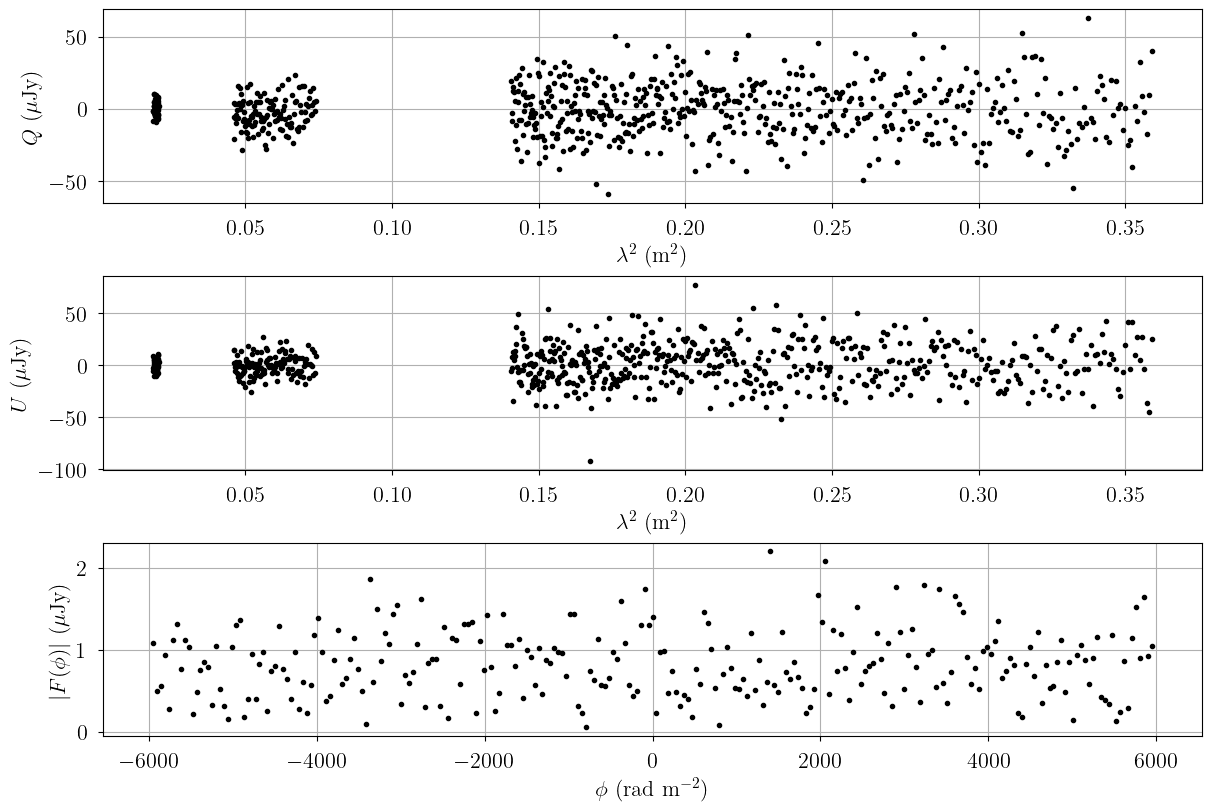

In [43]:
from bayes_spec import SpecData
from bayes_pol.utils import get_faraday_depth_params, calc_faraday_depth_abs

_C = 2.99792458e+08 # speed of light (m Hz)

# frequency windows (start_edge (Hz), stop_edge (Hz), spectral rms (uJy), n_channels)
freq_windows = [
    (0.5e9, 0.8e9, 513, 20.0),
    (1.1e9, 1.4e9, 127, 10.0),
    (2.1e9, 2.2e9, 64, 5.0),
]
freq_bin_edges = [
    np.linspace(window[0], window[1], window[2]+1)
    for window in freq_windows
]

# lamda^2 windows (start_edge (m2), stop_edge (m2), spectral rms (uJy), n_channels)
lam2_windows = [
    ((_C/window[1])**2.0, (_C/window[0])**2.0, window[2], window[3])
    for window in freq_windows[::-1]
]
lam2_window_widths = [window[1] - window[0] for window in lam2_windows]
lam2_bin_edges = [(_C/edges[::-1])**2.0 for edges in freq_bin_edges[::-1]]
lam2_bin_centers = [
    edges[:-1] + np.diff(edges)/2.0
    for edges in lam2_bin_edges
]
lam2_channel_widths = [np.diff(edges) for edges in lam2_bin_edges]

# lambda^2 data axis
lam2_axis = np.concatenate(lam2_bin_centers)

# data noise array
rms = np.concatenate([window[3]*np.ones(window[2]) for window in lam2_windows])

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
stokesQ = rms * np.random.randn(len(lam2_axis)) # uJy
stokesU = rms * np.random.randn(len(lam2_axis)) # uJy

# Faraday depth spectral axis, wraps at pi (rad/m2)
N_freqs = 255
lam2_chan = np.min(np.concatenate(lam2_channel_widths))
faraday_width = 0.1 * np.pi/lam2_chan
faraday_depth_axis = np.linspace(-faraday_width/2.0, faraday_width/2.0, N_freqs)

# Faraday depth spectrum (uJy)
faraday_params = get_faraday_depth_params(lam2_axis, faraday_depth_axis)
faraday_depth_abs = calc_faraday_depth_abs(stokesQ, stokesU, *faraday_params).eval()

obs_Q = SpecData(
    lam2_axis,
    stokesQ,
    rms,
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$Q$ ($\mu$Jy)",
)
obs_U = SpecData(
    lam2_axis,
    stokesU,
    rms,
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$U$ ($\mu$Jy)",
)
obs_faraday_depth_abs = SpecData(
    faraday_depth_axis,
    faraday_depth_abs,
    1.0, # ignored
    xlabel=r"$\phi$ (rad m$^{-2}$)",
    ylabel=r"$|F(\phi)|$ ($\mu$Jy)",
)
dummy_data = {
    "Q": obs_Q,
    "U": obs_U,
    "faraday_depth_abs": obs_faraday_depth_abs,
}

# Plot the simulated data
fig, axes = plt.subplots(len(dummy_data), figsize=(12, 8), layout="constrained", squeeze=False)
for ax, dataset in zip(axes.ravel(), dummy_data.values()):
    ax.plot(dataset.spectral, dataset.brightness, "k.")
    ax.set_xlabel(dataset.xlabel)
    ax.set_ylabel(dataset.ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.

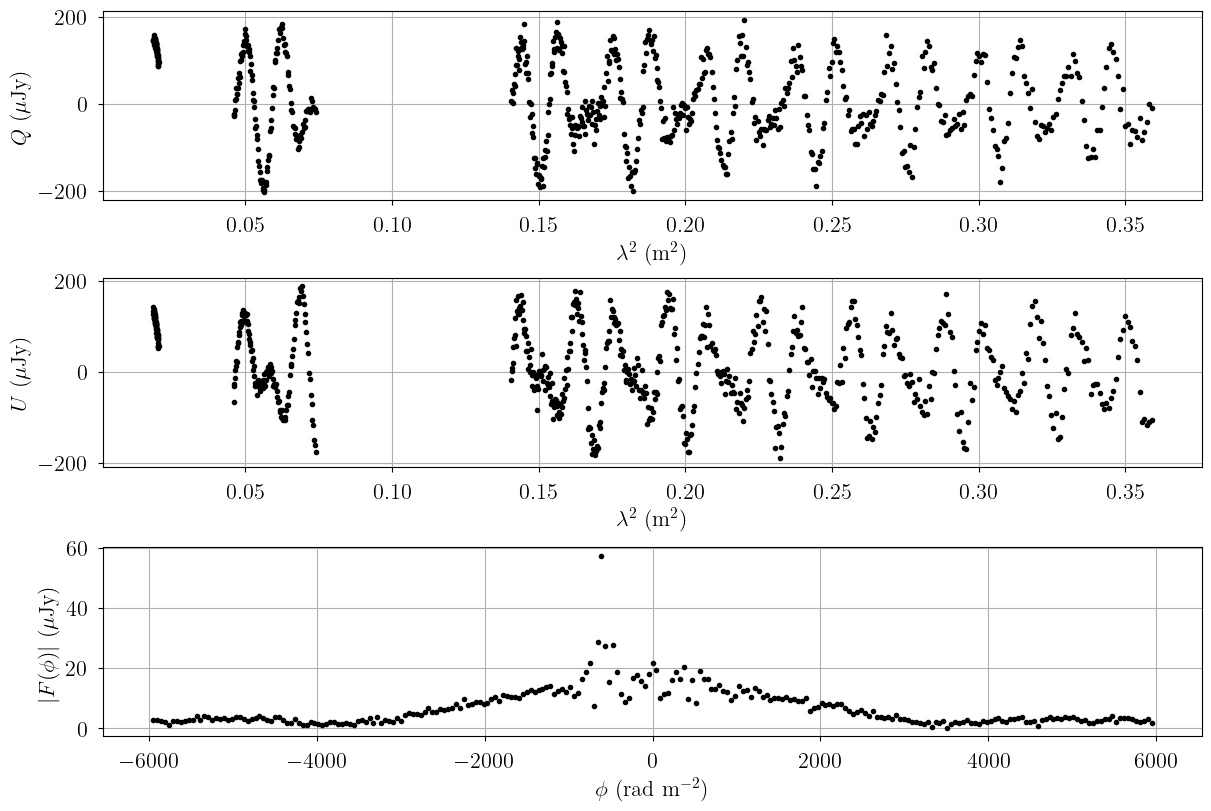

In [44]:
from bayes_pol import FaradayModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
model = FaradayModel(
    dummy_data,
    n_clouds=n_clouds,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_polarized_intensity = 100.0,
    prior_faraday_depth_mean = [0.0, 100.0],
    prior_faraday_depth_fwhm = 10.0,
    prior_faraday_depth_offset = [0.0, 1.0],
    prior_faraday_depth_sigma = 1.0,
)
model.add_likelihood()

sim_params = {
    "polarized_intensity": [100.0, 100.0],
    "faraday_depth_mean": [-300.0, 200.0],
    "faraday_depth_fwhm": [5.0, 0.0],
    "pol_angle0": [-0.4, 0.25],
}
sim_obs = {
    key: model.model[key].eval(sim_params, on_unused_input="ignore")
    for key in dummy_data.keys()
}
faraday_depth_abs = calc_faraday_depth_abs(sim_obs["Q"], sim_obs["U"], *faraday_params).eval()

# Save simulated data
obs_Q = SpecData(
    lam2_axis,
    sim_obs["Q"],
    rms,
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$Q$ ($\mu$Jy)",
)
obs_U = SpecData(
    lam2_axis,
    sim_obs["U"],
    rms,
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$U$ ($\mu$Jy)",
)
obs_faraday_depth_abs = SpecData(
    faraday_depth_axis,
    faraday_depth_abs,
    1.0, # ignored
    xlabel=r"$\phi$ (rad m$^{-2}$)",
    ylabel=r"$|F(\phi)|$ ($\mu$Jy)",
)
data = {
    "Q": obs_Q,
    "U": obs_U,
    "faraday_depth_abs": obs_faraday_depth_abs,
}

# Plot the simulated data
fig, axes = plt.subplots(len(data), figsize=(12, 8), layout="constrained", squeeze=False)
for ax, dataset in zip(axes.ravel(), data.values()):
    ax.plot(dataset.spectral, dataset.brightness, "k.")
    ax.set_xlabel(dataset.xlabel)
    ax.set_ylabel(dataset.ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `FaradayModel`. Here we create a new model with the simulated data.

In [46]:
# Initialize and define the model
model = FaradayModel(
    data,
    n_clouds=n_clouds,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_polarized_intensity = 100.0,
    prior_faraday_depth_mean = [0.0, 100.0],
    prior_faraday_depth_fwhm = 10.0,
    prior_faraday_depth_offset = [0.0, 1.0],
    prior_faraday_depth_sigma = 1.0,
)
model.add_likelihood()

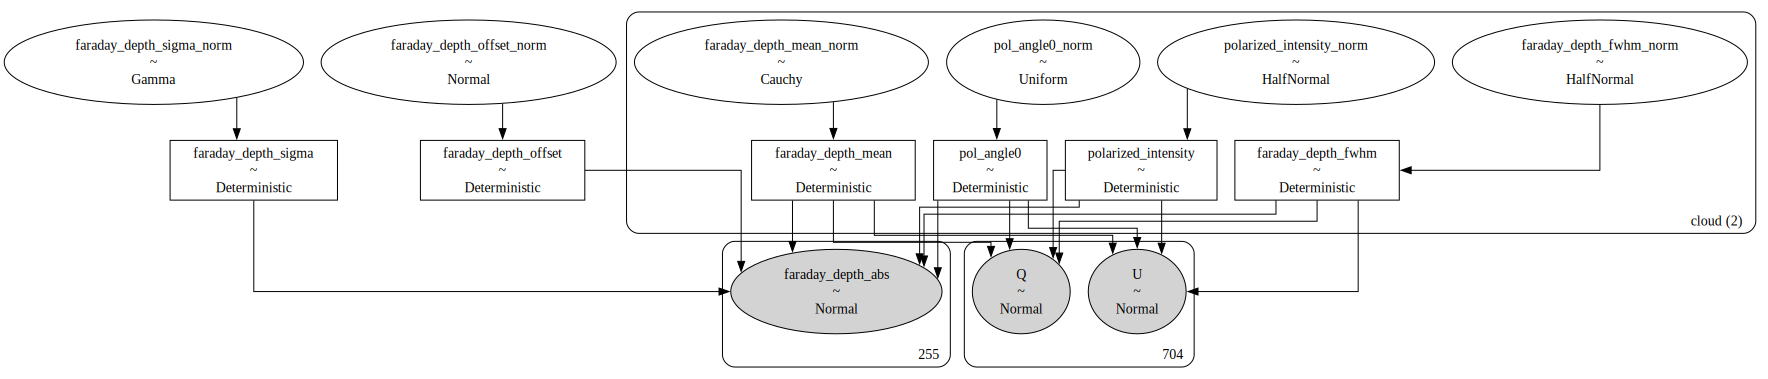

In [47]:
# Plot model graph
model.graph().render('faraday_model', format='png')
model.graph()

In [48]:
# model string representation
print(model.model.str_repr())

 polarized_intensity_norm ~ HalfNormal(0, 1)
  faraday_depth_mean_norm ~ Cauchy(0, 1)
  faraday_depth_fwhm_norm ~ HalfNormal(0, 1)
          pol_angle0_norm ~ Uniform(-3.14, 3.14)
faraday_depth_offset_norm ~ Normal(0, 1)
 faraday_depth_sigma_norm ~ Gamma(2, f())
      polarized_intensity ~ Deterministic(f(polarized_intensity_norm))
       faraday_depth_mean ~ Deterministic(f(faraday_depth_mean_norm))
       faraday_depth_fwhm ~ Deterministic(f(faraday_depth_fwhm_norm))
               pol_angle0 ~ Deterministic(f(pol_angle0_norm))
     faraday_depth_offset ~ Deterministic(f(faraday_depth_offset_norm))
      faraday_depth_sigma ~ Deterministic(f(faraday_depth_sigma_norm))
                        Q ~ Normal(f(polarized_intensity_norm, pol_angle0_norm, faraday_depth_mean_norm, faraday_depth_fwhm_norm), <constant>)
                        U ~ Normal(f(polarized_intensity_norm, pol_angle0_norm, faraday_depth_mean_norm, faraday_depth_fwhm_norm), <constant>)
        faraday_depth_abs ~ Normal(

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [Q, U, faraday_depth_abs, faraday_depth_fwhm_norm, faraday_depth_mean_norm, faraday_depth_offset_norm, faraday_depth_sigma_norm, pol_angle0_norm, polarized_intensity_norm]


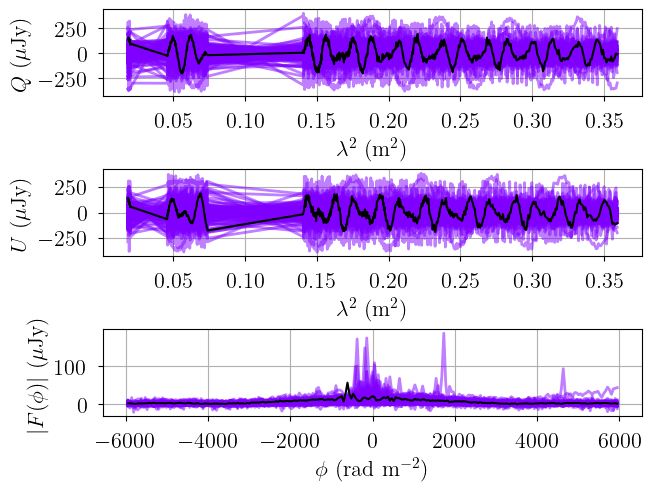

In [49]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

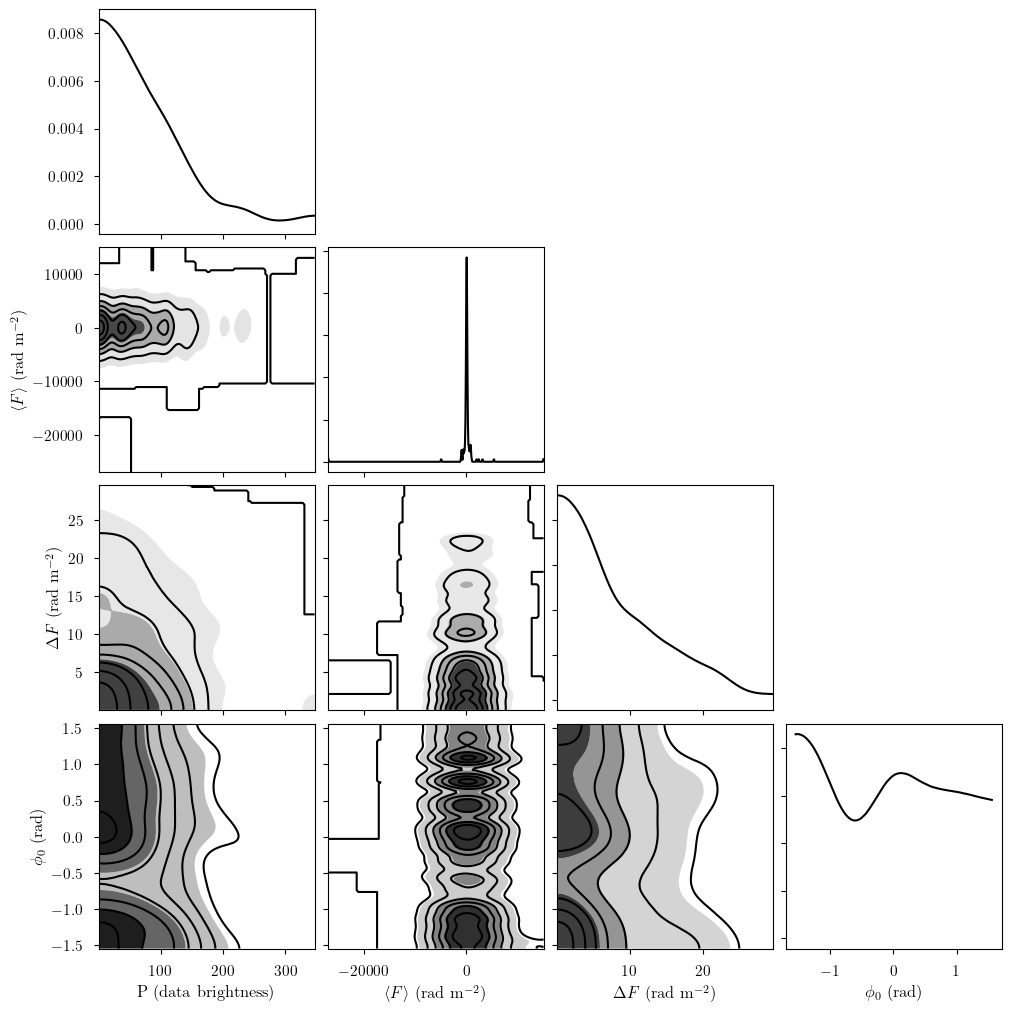

In [50]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior, # samples
    model.cloud_deterministics,
    labeller=model.labeller, # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [51]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Interrupted at 88,435 [88%]: Average Loss = 28,562


Output()

Runtime: 6.70 minutes


In [52]:
# ignore transition and state dependent parameters
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
faraday_depth_fwhm[0],31.742,0.225,31.349,32.223,0.007,0.005,1018.0,1023.0,NaN
faraday_depth_fwhm[1],12.471,0.450,11.600,13.292,0.015,0.011,903.0,736.0,NaN
faraday_depth_fwhm_norm[0],3.174,0.023,3.135,3.222,0.001,0.000,1018.0,1023.0,NaN
faraday_depth_fwhm_norm[1],1.247,0.045,1.160,1.329,0.001,0.001,903.0,736.0,NaN
faraday_depth_mean[0],4.293,0.095,4.121,4.475,0.003,0.002,943.0,906.0,NaN
faraday_depth_mean[1],-18.303,0.191,-18.693,-17.988,0.006,0.004,924.0,849.0,NaN
faraday_depth_mean_norm[0],0.043,0.001,0.041,0.045,0.000,0.000,943.0,906.0,NaN
faraday_depth_mean_norm[1],-0.183,0.002,-0.187,-0.180,0.000,0.000,924.0,849.0,NaN
faraday_depth_offset,-0.533,0.221,-0.963,-0.144,0.007,0.005,973.0,886.0,NaN
faraday_depth_offset_norm,-0.533,0.221,-0.963,-0.144,0.007,0.005,973.0,886.0,NaN


Sampling: [Q, U, faraday_depth_abs]


Output()

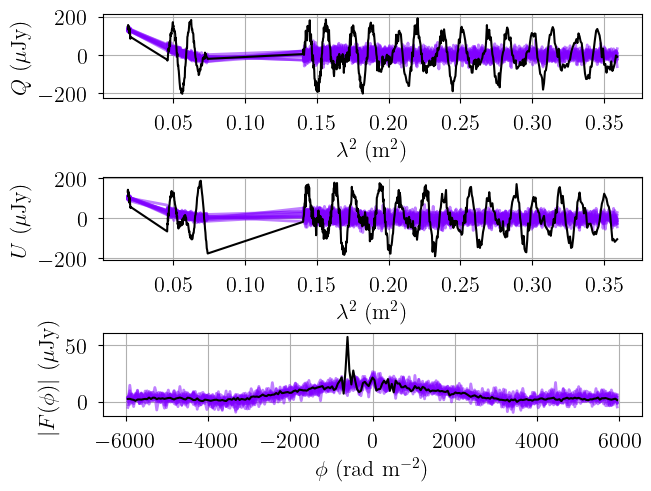

In [53]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [22]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.01, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Interrupted at 25,060 [25%]: Average Loss = 16,250
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [polarized_intensity_norm, faraday_depth_mean_norm, faraday_depth_fwhm_norm, pol_angle0_norm, faraday_depth_offset_norm, faraday_depth_sigma_norm]


Output()

Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 46 seconds.


Adding log-likelihood to trace


Output()

Runtime: 2.42 minutes


In [23]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [24]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
polarized_intensity[0],101.371,0.505,100.432,102.348,0.006,0.005,6229.0,5176.0,1.0
faraday_depth_mean[0],100.040,0.039,99.967,100.115,0.001,0.000,5136.0,4479.0,1.0
faraday_depth_fwhm[0],5.208,0.081,5.055,5.359,0.001,0.001,6258.0,4938.0,1.0
pol_angle0[0],-0.402,0.003,-0.408,-0.396,0.000,0.000,5290.0,4317.0,1.0
faraday_depth_offset,-0.209,0.056,-0.315,-0.105,0.001,0.000,6794.0,4796.0,1.0
faraday_depth_sigma,0.609,0.038,0.542,0.683,0.000,0.000,7332.0,4709.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [Q, U, faraday_depth_abs]


Output()

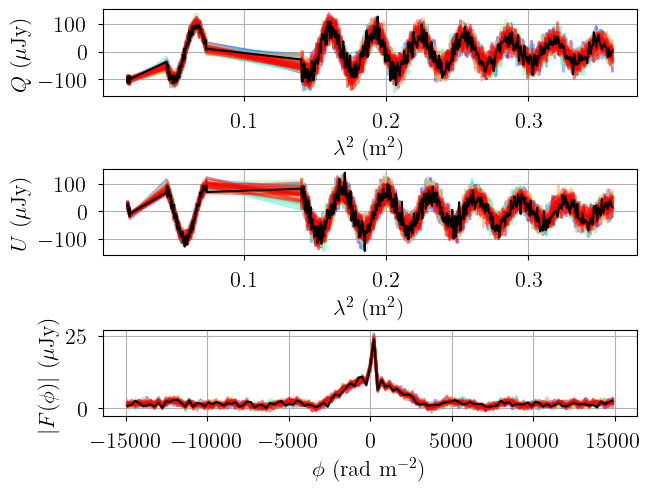

In [25]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

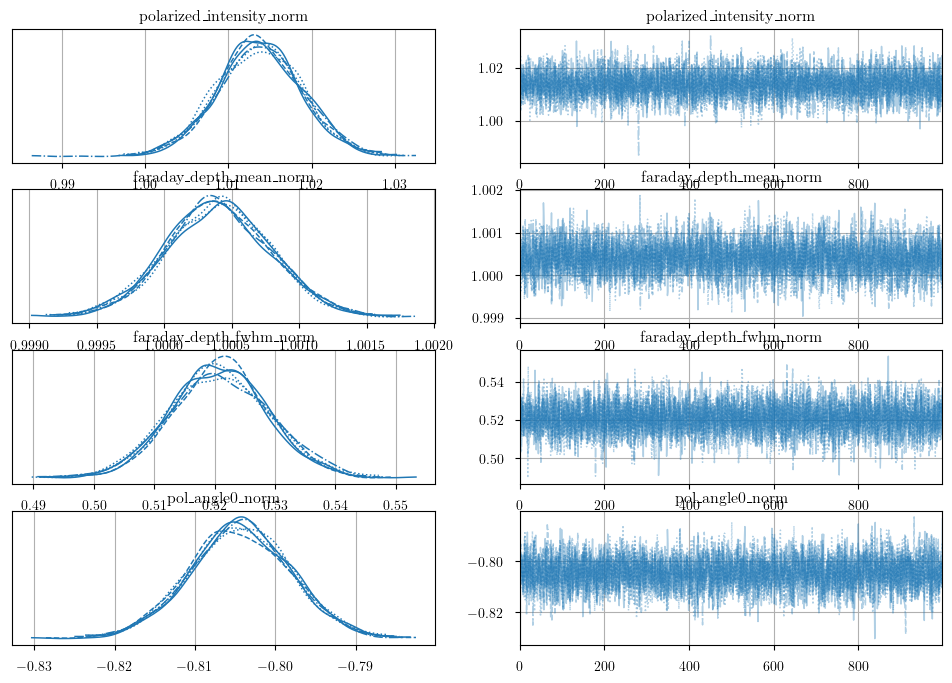

In [26]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

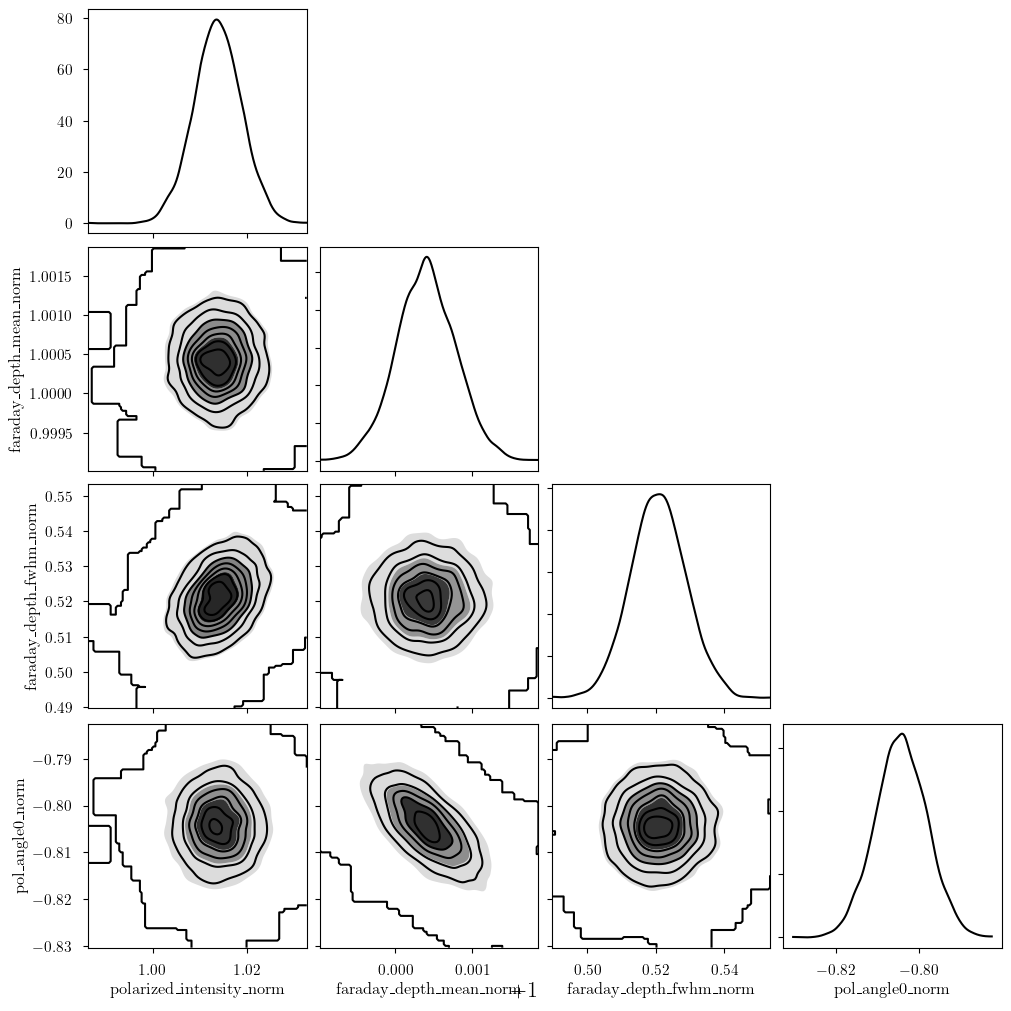

In [27]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

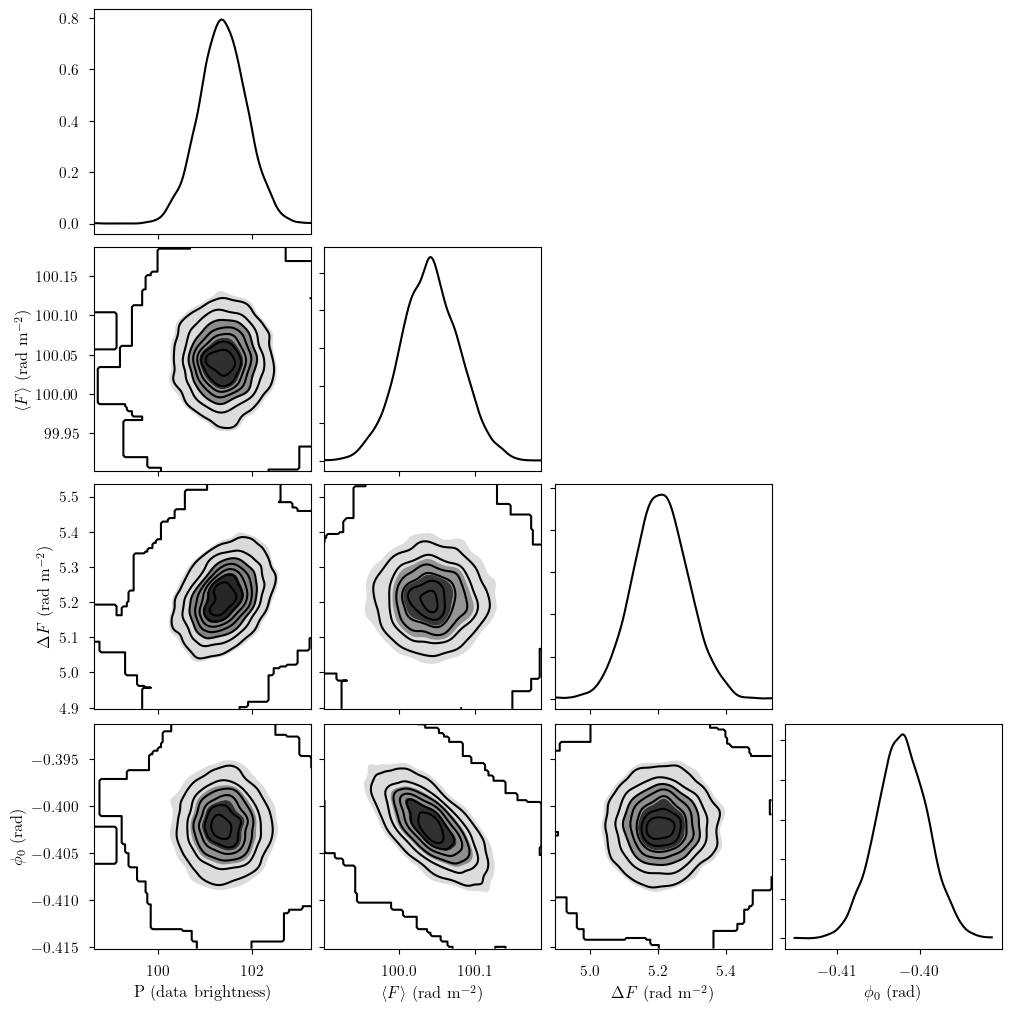

In [28]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [29]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

KeyError: "not all values found in index 'cloud'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [ ]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)